In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from joblib import dump, load
import pickle

def Graph_Confusion_Matrix(CM, labels, title = 'Confusion Matrix'):
    #np.fill_diagonal(CM,0)

    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(CM, annot=True,annot_kws={"size": 16},  fmt='.1f' # fmt='g'
               ,xticklabels = labels
               ,yticklabels = labels)# font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


def Normalisation(X):
    #X = X.values
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_norm = (X - X_mean)/X_std
    return(X_norm, X_mean, X_std)
    
def Max_Min_Norm(X):
    #X = X.values
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_norm = (X-X_min)/(X_max-X_min)
    return(X_norm, X_min, X_max)


plt.style.use('bmh')

In [2]:
df = pd.read_csv("Data/Train_Data_Aft_FE.csv")
#df = pd.read_csv("Data/Train_Data_Aft_FE_ML_Age_Trial.csv")
df = df.set_index("URN")
K_mean = load('Parameter_Dictionary/k-means.joblib') 

#Load dictionary that has mean and std for k-means
with open('Parameter_Dictionary/K_means_Dict.pickle', 'rb') as handle:
    Para_Dict = pickle.load(handle)

#df.drop(["Mosaic Group Num"],axis=1, inplace=True)


E:\Anaconda\envs\ML\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Need to add on the customer segments

In [3]:
df_k_means = df[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means["Recency"] = np.where((df_k_means['NUM_TRANS_LST_24']>0),1,0)

X_k_means = (df_k_means.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [4]:
df = pd.concat([df,pd.Series(K_mean.predict(X_k_means), index=df.index)],axis=1)
df.rename(columns={0:"Clusters"}, inplace=True)

df.drop(['Months Between DateCr and Last Ask',
'AGE',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'Total_C0',
'NUM_TRANS_LST_24',
'DONATED_LST_24'], axis=1, inplace=True)

In [5]:
Num_DV_1 = len(df.loc[df["DV"] == 1])

df_final = pd.concat([df.loc[df["DV"] == 1], df.loc[df["DV"] == 0].sample(Num_DV_1, random_state=32)]).copy()
df_final = df_final.sample(frac=1, random_state=53)#.reset_index(drop=True)

Num_DV_0 = len(df.loc[df["DV"] == 0])

df_final = pd.concat([df.loc[df["DV"] == 1].sample(Num_DV_0, replace=True), df.loc[df["DV"] == 0]]).copy()
df_final = df_final.sample(frac=1, random_state=53)#.reset_index(drop=True)

In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19036 entries, 87358 to 28144
Data columns (total 31 columns):
DV                                    19036 non-null int64
INCOME                                9518 non-null float64
APPEAL_AVG_GIFT                       19036 non-null float64
EMERG_AVG_GIFT                        19036 non-null float64
EMAIL_FLAG                            19036 non-null int64
NUM_ACTIVE_COG                        19036 non-null int64
NUM_ATTRITED_COG                      19036 non-null int64
NUM_DIFF_COG                          19036 non-null int64
TOTAL_YEARLY_CHARGE                   19036 non-null float64
TOTAL_NUM_MONTH_PAID                  19036 non-null int64
DM_PREVIOUS_12_MONTHS                 19036 non-null int64
NUM_TRANS_LST_24                      19036 non-null int64
DONATED_LST_24                        19036 non-null float64
Months Between DateCr and Last Ask    19036 non-null float64
Mosaic Group Num                      19036 non-nu

In [7]:
y = df_final["DV"].copy()
X = df_final.drop(["DV","INCOME"],axis=1).copy()

In [8]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = [{'n_estimators': [128], 
                     'max_features': [2, 4, 6, 8, 10],
                     'min_samples_leaf':[5,10,20,30,50,100]
                    }]
scores = ['precision', 'recall']

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters,   cv=5, scoring = 'accuracy', verbose= 5)
clf.fit(X[Feature_Importance.head(17).index], y)
print(clf.best_params_)

In [9]:
Feature_Importance = pd.read_csv("Data/Feature_Importance.csv", index_col=0)
Feature_Importance.head(12).index

Index(['WRR_EMERG', 'NUM_TRANS_LST_24', 'WRR_APP', 'EMERG_AVG_GIFT', 'AGE',
       'APPEAL_AVG_GIFT', 'TOWN_Encoded', 'DM_PREVIOUS_12_MONTHS',
       'COG_TYPE_Encoded', 'Months Between DateCr and Last Ask',
       'DONATED_LST_24', 'EMAIL_FLAG'],
      dtype='object')

In [10]:
#Best_Features = X.columns
Best_Features = Feature_Importance.head(17).index

Model = RandomForestClassifier(n_estimators = 128,
                               max_features = 8, 
                               min_samples_leaf = 10,
                               n_jobs=-1)

Acc_Train = []
Acc = []
Recall = []
Precision = []

labels=[1,0]

folds = KFold(n_splits=10, shuffle=False)#, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):    
    
    print("Kfold: ",fold_)
    
    Model.fit(X.iloc[trn_idx][Best_Features], y.iloc[trn_idx])

    y_pred_prob = Model.predict_proba(X.iloc[val_idx][Best_Features])[:,1]
    
    y_pred = y_pred_prob >= 0.5
    
    #CM )= confusion_matrix(y.iloc[val_idx].values, y_pred, labels)
    #Graph_Confusion_Matrix(CM, labels)
    
    Y_actual = y.iloc[val_idx]
    
    Acc_Train.append(accuracy_score(y.iloc[trn_idx], Model.predict(X.iloc[trn_idx][Best_Features]))*100)
    
    Acc.append(accuracy_score(Y_actual, y_pred)*100)
    Recall.append(recall_score(Y_actual, y_pred)*100)
    Precision.append(precision_score(Y_actual, y_pred)*100)

    #print("Accuary:", accuracy_score(Y_actual, y_pred)*100)
    #print("Recall:", recall_score(Y_actual, y_pred)*100)
    #print("Precision:", precision_score(Y_actual, y_pred)*100)
    
    if fold_ == 0:
        Outcome_df = pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1)
    else:
        Outcome_df = Outcome_df.append(pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1), sort=False)
        
Outcome_df.rename(index=str, columns={0:"Score"}, inplace=True)

print("Avg Accuracy Train Set:", np.mean(Acc_Train))
print("Avg Accuracy Test Set:",np.mean(Acc))
print("")
print("Avg Recall:",np.mean(Recall))
print("Avg Precision:",np.mean(Precision))

#Outcome_df.to_csv("Model Outputs/Random_forest.csv", index=True)

Kfold:  0
Kfold:  1
Kfold:  2
Kfold:  3
Kfold:  4
Kfold:  5
Kfold:  6
Kfold:  7
Kfold:  8
Kfold:  9
Avg Accuracy Train Set: 86.34925569399851
Avg Accuracy Test Set: 79.45486891551157

Avg Recall: 76.80513919018199
Avg Precision: 81.12903912909559


##### We want to use feature gain and do a feed forward selection 

Train_Acc = []
Test_Acc = []
Test_Recall = []

for i in range(1,30):

    Best_Features = Feature_Importance.head(i).index


    Model = RandomForestClassifier(n_estimators = 128,
                                   #min_samples_leaf = 20,
                                   n_jobs=-1)

    Acc_Train = []
    Acc = []
    Recall = []
    Precision = []

    labels=[1,0]

    folds = KFold(n_splits=5, shuffle=False)#, random_state=42)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):    

        print("Kfold: ",fold_)

        Model.fit(X.iloc[trn_idx][Best_Features], y.iloc[trn_idx])

        y_pred_prob = Model.predict_proba(X.iloc[val_idx][Best_Features])[:,1]

        y_pred = y_pred_prob >= 0.5

        #CM )= confusion_matrix(y.iloc[val_idx].values, y_pred, labels)
        #Graph_Confusion_Matrix(CM, labels)

        Y_actual = y.iloc[val_idx]

        Acc_Train.append(accuracy_score(y.iloc[trn_idx], Model.predict(X.iloc[trn_idx][Best_Features]))*100)

        Acc.append(accuracy_score(Y_actual, y_pred)*100)
        Recall.append(recall_score(Y_actual, y_pred)*100)
        Precision.append(precision_score(Y_actual, y_pred)*100)
        
    Outcome_df.rename(index=str, columns={0:"Score"}, inplace=True)

    print("Avg Accuracy Train Set:", np.mean(Acc_Train))
    print("Avg Accuracy Test Set:",np.mean(Acc))
    print("")
    print("Avg Recall:",np.mean(Recall))
    print("Avg Precision:",np.mean(Precision))
    
    Train_Acc.append(np.mean(Acc_Train))
    Test_Acc.append(np.mean(Acc))
    Test_Recall.append(np.mean(Recall))

    #Outcome_df.to_csv("Model Outputs/Random_forest.csv", index=True)

plt.plot(range(1,i+1), Train_Acc, linestyle='-', marker='o', color='b', label="Train Accuracy")
plt.plot(range(1,i+1), Test_Acc,  linestyle='-', marker='o', color='orange', label="Validation Accuracy")
#plt.plot(range(1,i), Test_Recall,  linestyle='-', marker='o', color='green', label="Test Recall")
plt.xticks(range(1,i+1,2))
plt.title("Feature Selection")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [11]:
Feature_Importance.head(17)

,Gain
WRR_EMERG,0.351050
NUM_TRANS_LST_24,0.161773
WRR_APP,0.087292
EMERG_AVG_GIFT,0.062910
AGE,0.054218
APPEAL_AVG_GIFT,0.050191
TOWN_Encoded,0.043340
DM_PREVIOUS_12_MONTHS,0.042778
COG_TYPE_Encoded,0.031073
Months Between DateCr and Last Ask,0.024793


### How is the model performing?

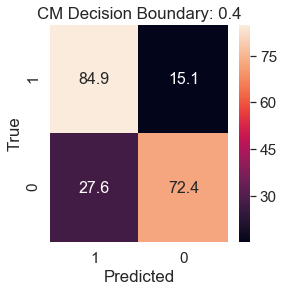

Accuracy: 78.69300273166631
Recall: 84.94431603278
Precision: 75.50429585356743


In [12]:
Boundry = 0.4

CM = confusion_matrix(Outcome_df["DV"], Outcome_df["Score"]>=Boundry, labels)

#Normalise so is a percentage
CM = np.divide(CM,np.sum(CM, axis=1).reshape(2,-1)) * 100

Graph_Confusion_Matrix(CM, labels, 'CM Decision Boundary: '+str(Boundry))

print("Accuracy:", accuracy_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Recall:", recall_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Precision:", precision_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)

In [13]:
fpr, tpr, _ = roc_curve(Outcome_df["DV"], Outcome_df["Score"])
roc_auc = auc(fpr, tpr)

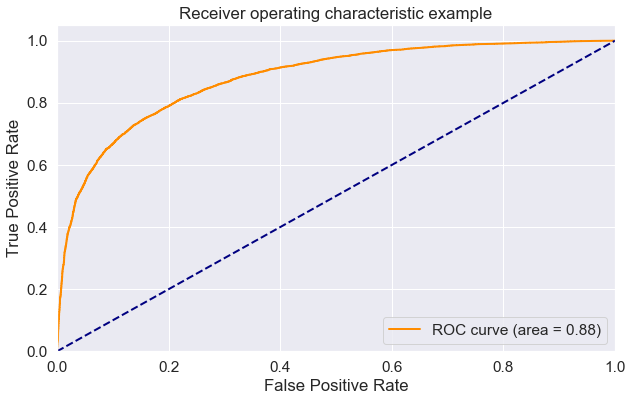

In [14]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
Outcome_df["Score Band"] = Outcome_df["Score"].astype(str).str.slice(0,3)

### I am now going to do the same to this dataset and add on the customer segments

In [16]:
df_Val = pd.read_csv("Data/Test_Data_Val_Aft_FE.csv")
df_Val = df_Val.set_index("URN")

#df_Val.drop(["Mosaic Group Num"],axis=1, inplace=True)

In [17]:
df_k_means_val = df_Val[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means_val["Recency"] = np.where((df_k_means_val['NUM_TRANS_LST_24']>0),1,0)

X_k_means_val = (df_k_means_val.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [18]:
df_Val = pd.concat([df_Val,pd.Series(K_mean.predict(X_k_means_val), index=df_Val.index)],axis=1)
df_Val.rename(columns={0:"Clusters"}, inplace=True)

### We need to build the model on all of the data

In [19]:
Best_Features = Feature_Importance.head(17).index

Model = RandomForestClassifier(n_estimators = 128,
                               max_features = 8, 
                               min_samples_leaf = 10,
                               n_jobs=-1)

Model.fit(X[Best_Features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=128,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Save model to disk

In [20]:
dump(Model, 'Parameter_Dictionary/RF_Tree_128.joblib') 

['Parameter_Dictionary/RF_Tree_128.joblib']

## Let check the net profit and response rate for the unbalanced dataset

In [21]:
Results_Val = df_Val[["DV", "INCOME"]].copy()
Results_Val["Score"] =  Model.predict_proba(df_Val.drop(["DV", "INCOME"],axis=1)[Best_Features].values)[:,1]
Results_Val["Score Band"] = Results_Val["Score"].astype(str).str.slice(0,3)
                                                                       
#Results_Val.to_csv("Model Outputs/RF_UB_VAL.csv", index=True)

In [22]:
Results_Val_2 = Results_Val.groupby(["Score Band"])["INCOME"].agg(["count", "sum", "mean","median","std" ,"max"])
Results_Val_2 = pd.concat([Results_Val["Score Band"].value_counts().sort_index(), Results_Val_2],axis=1).rename(index=str
                                                                                                                 ,columns={"count":"Donors"
                                                                                                                           ,"Score Band": "Contacted Volume"
                                                                                                                           ,"sum": "Total Value"
                                                                                                                           ,"mean": "Mean Gift"
                                                                                                                           ,"median": "Median Gift"
                                                                                                                           ,"max":"Max Gift"})



In [23]:
Results_Val_2["Cost"]= Results_Val_2["Contacted Volume"] * 2.50
Results_Val_2["Net Profit"] = Results_Val_2["Total Value"] - Results_Val_2["Cost"]
Results_Val_2["RR"] = (Results_Val_2["Donors"]/Results_Val_2["Contacted Volume"])
Results_Val_2

,Contacted Volume,Donors,Total Value,Mean Gift,Median Gift,std,Max Gift,Cost,Net Profit,RR
Score Band,,,,,,,,,,
0.0,2309,19,505.00,26.578947,20.0,22.794531,100.0,5772.5,-5267.50,0.008229
0.1,2019,30,1122.00,37.400000,30.0,25.751599,100.0,5047.5,-3925.50,0.014859
0.2,2235,67,2641.00,39.417910,30.0,38.116309,200.0,5587.5,-2946.50,0.029978
0.3,1965,85,3924.81,46.174235,30.0,60.014496,500.0,4912.5,-987.69,0.043257
0.4,1550,103,5430.00,52.718447,30.0,103.537378,1000.0,3875.0,1555.00,0.066452
0.5,1087,108,5600.00,51.851852,30.0,101.807480,1000.0,2717.5,2882.50,0.099356
0.6,703,115,5834.00,50.730435,30.0,73.509556,500.0,1757.5,4076.50,0.163585
0.7,533,141,7368.00,52.255319,30.0,89.288169,1000.0,1332.5,6035.50,0.264540
0.8,469,185,10440.00,56.432432,30.0,72.331416,520.0,1172.5,9267.50,0.394456
